# WEATHER IMAGE CLASSIFICATION

**This project shows the Image Classification of a Weather Image Recognition dataset on Kaggle.**

https://www.kaggle.com/datasets/jehanbhathena/weather-dataset/data

**Context**

    This dataset contains 6862 images of different types of weather, it can be used to implement weather classification based on the photo.

**Content**

    The pictures are divided into 11 classes: dew, fog/smog, frost, glaze, hail, lightning , rain, rainbow, rime, sandstorm and snow.


##Import the modules

The path to the dataset => usr/local/dataset/[sub-class]

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Unzip the dataset

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/"

archive.zip  classifier.ipynb


Dataset is located to (/content/drive/MyDrive/Colab_Notebooks/archive.zip) and is being unzipped

The path to the dataset => usr/local/dataset/[sub-class]

In [ ]:
!unzip -o '/content/drive/My Drive/Colab Notebooks/archive.zip' -d '/usr/local/dataset'

##Data Preparation

In this section, data augmentation is being used to train data. Data also gets split into train and validation.


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True,
    #rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range = (0.5, 1.5),
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/usr/local/dataset/dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    '/usr/local/dataset/dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


##Pre-trained model

In this section a pretrained model is being used to increase the metrics of the program. With Transfer Learning new layers on top for the task (11 weather classes) are being added and they are the only ones that are being trained.

In [ ]:
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False, # include only load the layers that are used for feature extraction (use pre trained layers and train the last)
    weights='imagenet'
)
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x) # combines and interprets features
x = Dropout(0.3)(x)
predictions = Dense(11, activation='softmax')(x)  # 11 classes

model = Model(inputs=base_model.input, outputs=predictions)

##Compile the model

The modeling is being compiled with Adam, Lr = 0.001. Also there is Early Stopping that can prevent overfitting.

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)


##Train the model

In this section the model is being trained and also there's the following plots:
1. Accuracy Over Epochs
2. Loss over Epochs

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Other results

    1) MobileNetV2 , Dropout = 0.5 , Adam
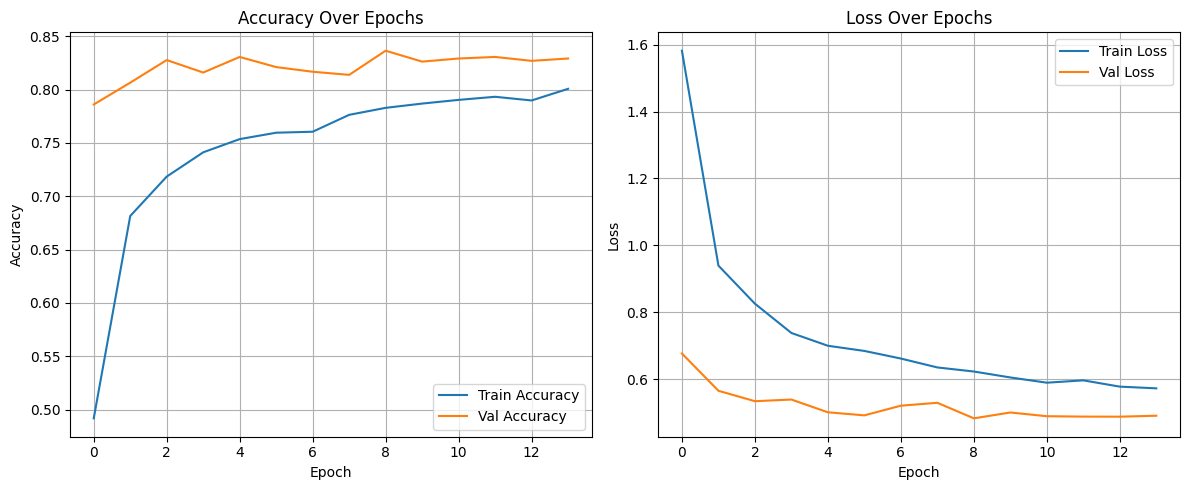

    2) MobileNetV2 , Dropout = 0.5 , AdamW

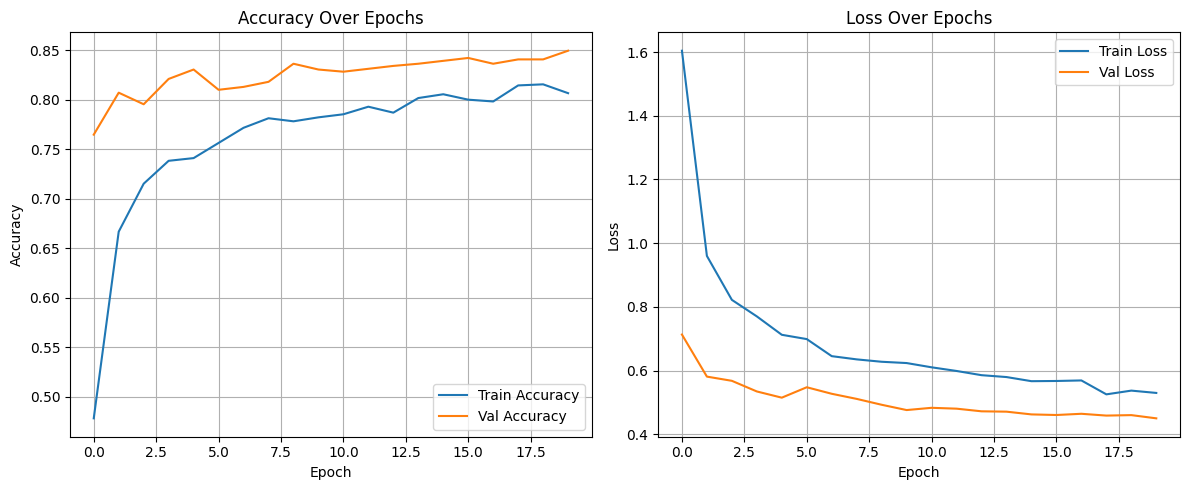

    3) ResNet152V2 , Dropout = 0.5 , AdamW

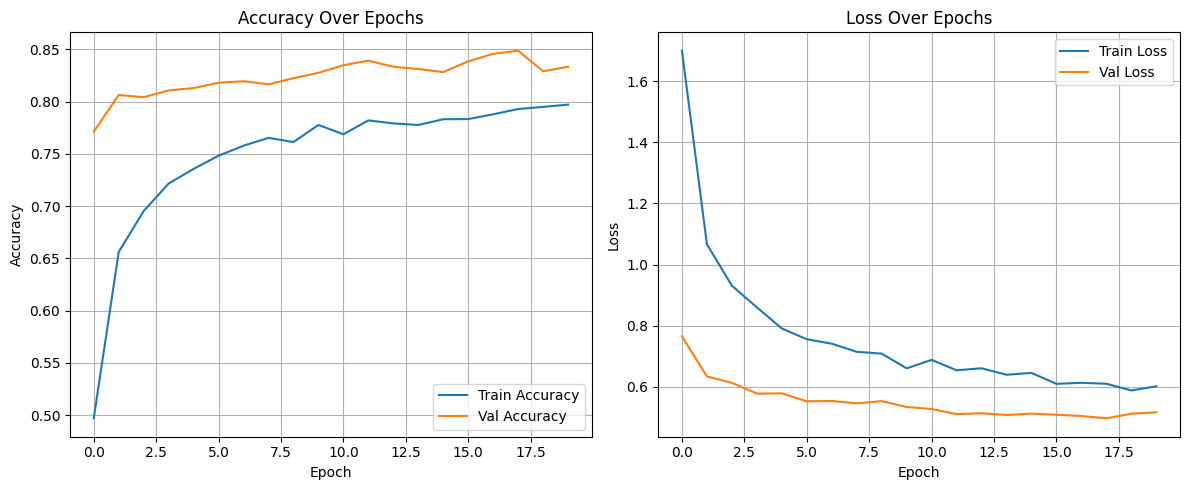

    4) Base model + a lot more data augmentation

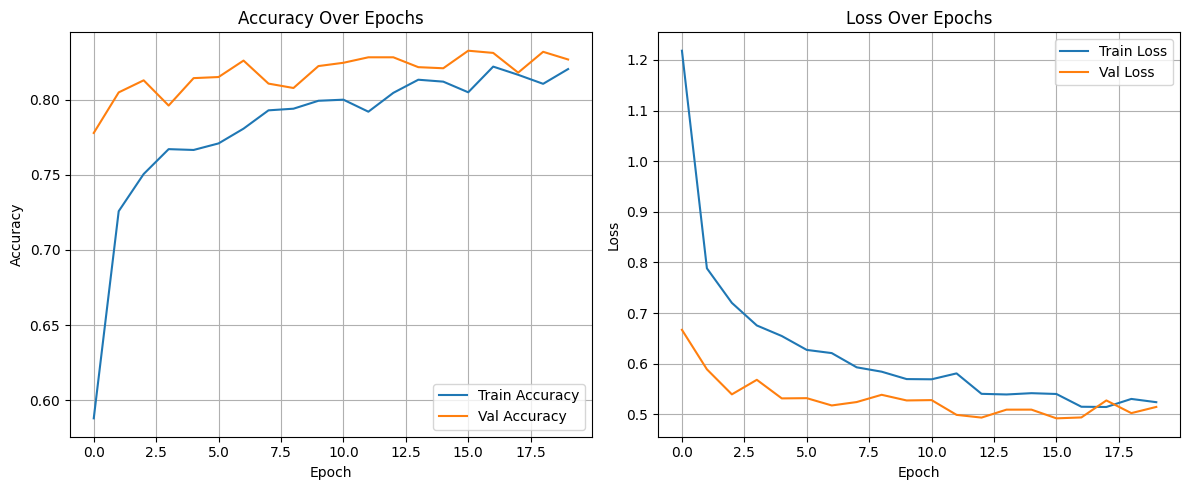

## Test the model

The model is being tested so that we can evaluate if the prediction was right or not. (Replace the img_path each time for test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


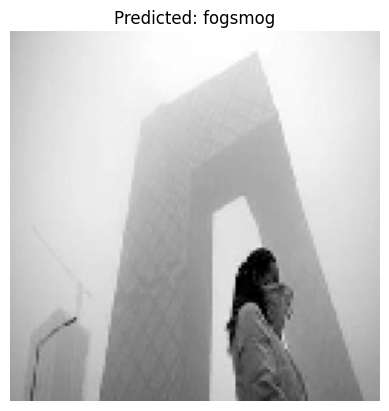

In [ ]:
img_path = '/usr/local/dataset/dataset/fogsmog/4075.jpg'

img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
preds = model.predict(img_array)
predicted_index = np.argmax(preds)
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
predicted_label = index_to_class[predicted_index]

# Display prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

# Convert to .html

In [ ]:
!jupyter nbconvert --to html classifier.ipynb